[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Priesemann-Group/covid19_inference/blob/model_cleanup/scripts/interactive/example_one_bundesland.ipynb)

In [1]:
!pip install git+https://github.com/Priesemann-Group/covid19_inference.git



# Example for one region (bundesland)
Non-hierarchical model using rki data.

Runtime ~ 15 min

The first thing we need to do is import some essential stuff. Theses have to be installed and are prerequisites.


In [2]:
import datetime
import time as time_module
import sys
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats
import theano
import theano.tensor as tt
import pymc3 as pm

In [3]:
# Now to the fun stuff, we import our module!
try:
    import covid19_inference as cov19
except ModuleNotFoundError:
    sys.path.append("../../")
    import covid19_inference as cov19


## Data retrieval

The next thing we want to do is load a dataset from somewhere.
There are multiple download sources which can be found [here](https://covid19-inference.readthedocs.io/en/latest/doc/data_retrieval.html).
In this example we will use the RKI dataset.


In [4]:
rki = cov19.data_retrieval.RKI()  # It is important to download the dataset!
rki.download_all_available_data()
# One could also parse True to the constructor of the class to force an auto download

INFO     [covid19_inference.data_retrieval.retrieval] Successfully loaded data from local




We can now access this downloaded data by the attribute
```
rki.data
```
but normally one would use the build in filter methods,
these can be found [here](https://covid19-inference.readthedocs.io/en/latest/doc/data_retrieval.html#covid19_inference.data_retrieval.JHU.get_new).

Next we retrieve the filtered data from our source in this example we will get all new cases and the total (cumulative) cases for the bundesland "Sachsen".


In [5]:
bd = datetime.datetime(2020, 3, 10)  # For the date filter
ed = datetime.datetime.now()

In [6]:
total_cases_obs = rki.get_total(
    value="confirmed", bundesland="Sachsen", data_begin=bd, data_end=ed
)
new_cases_obs = rki.get_new(
    value="confirmed", bundesland="Sachsen", data_begin=bd, data_end=ed
)



## Create the model

First we need to set the priors for the change points and other configs.


In [7]:
diff_data_sim = 16  # should be significantly larger than the expected delay, in
# order to always fit the same number of data points.
num_days_forecast = 10

In [8]:
# We set the priors for the changepoints here
prior_date_mild_dist_begin = datetime.datetime(2020, 3, 9)
prior_date_strong_dist_begin = datetime.datetime(2020, 3, 16)
prior_date_contact_ban_begin = datetime.datetime(2020, 3, 23)

In [9]:
change_points = [
    dict(
        pr_mean_date_transient=prior_date_mild_dist_begin,
        pr_sigma_date_transient=3,
        pr_median_lambda=0.2,
        pr_sigma_lambda=1,
    ),
    dict(
        pr_mean_date_transient=prior_date_strong_dist_begin,
        pr_sigma_date_transient=1.5,
        pr_median_lambda=1 / 8,
        pr_sigma_lambda=1,
    ),
    dict(
        pr_mean_date_transient=prior_date_contact_ban_begin,
        pr_sigma_date_transient=1.5,
        pr_median_lambda=1 / 8 / 2,
        pr_sigma_lambda=1,
    ),
]



Next, we create the model! There are default values for most of the function arguments,
but we will try to explicitly set all kwargs for the sake of this example.


In [10]:
params_model = dict(
    new_cases_obs=new_cases_obs[:],
    data_begin=bd,
    fcast_len=num_days_forecast,
    diff_data_sim=diff_data_sim,
    N_population=4e6,
)
# Median of the prior for the delay in case reporting, we assume 10 days
pr_delay = 10



The model is specified in a context. Each function in this context
has access to the model parameters set.


In [11]:
with cov19.model.Cov19Model(**params_model) as this_model:
    # Create the an array of the time dependent infection rate lambda
    lambda_t_log = cov19.model.lambda_t_with_sigmoids(
        pr_median_lambda_0=0.4,
        pr_sigma_lambda_0=0.5,
        change_points_list=change_points,  # The change point priors we constructed earlier
        name_lambda_t="lambda_t",  # Name for the variable in the trace (see later)
    )

    # set prior distribution for the recovery rate
    mu = pm.Lognormal(name="mu", mu=np.log(1 / 8), sigma=0.2)

    # This builds a decorrelated prior for I_begin for faster inference.
    # It is not necessary to use it, one can simply remove it and use the default argument
    # for pr_I_begin in cov19.SIR
    prior_I = cov19.model.uncorrelated_prior_I(
        lambda_t_log=lambda_t_log,
        mu=mu,
        pr_median_delay=pr_delay,
        name_I_begin="I_begin",
        name_I_begin_ratio_log="I_begin_ratio_log",
        pr_sigma_I_begin=2,
        n_data_points_used=5,
    )

    # Use lambda_t_log and mu to run the SIR model
    new_cases = cov19.model.SIR(
        lambda_t_log=lambda_t_log,
        mu=mu,
        name_new_I_t="new_I_t",
        name_I_t="I_t",
        name_I_begin="I_begin",
        pr_I_begin=prior_I,
    )

    # Delay the cases by a lognormal reporting delay
    new_cases = cov19.model.delay_cases(
        cases=new_cases,
        name_cases="delayed_cases",
        name_delay="delay",
        name_width="delay-width",
        pr_mean_of_median=pr_delay,
        pr_sigma_of_median=0.2,
        pr_median_of_width=0.3,
    )

    # Modulate the inferred cases by a abs(sin(x)) function, to account for weekend effects
    # Also adds the "new_cases" variable to the trace that has all model features.
    new_cases = cov19.model.week_modulation(
        cases=new_cases,
        name_cases="new_cases",
        name_weekend_factor="weekend_factor",
        name_offset_modulation="offset_modulation",
        week_modulation_type="abs_sine",
        pr_mean_weekend_factor=0.3,
        pr_sigma_weekend_factor=0.5,
        weekend_days=(6, 7),
    )

    # Define the likelihood, uses the new_cases_obs set as model parameter
    cov19.model.student_t_likelihood(new_cases)

INFO     [covid19_inference.model.spreading_rate] Lambda_t with sigmoids
INFO     [covid19_inference.model.model] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model.model] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model.model] relative_to_previous was set to default value False
INFO     [covid19_inference.model.model] pr_factor_to_previous was set to default value 1
INFO     [covid19_inference.model.model] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model.model] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model.model] relative_to_previous was set to default value False
INFO     [covid19_inference.model.model] pr_factor_to_previous was set to default value 1
INFO     [covid19_inference.model.model] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model.model] pr_sigma_transient_len was set to default value 0.5
INFO  


## MCM sampling

After the model is built, it is sampled using an MCMC sampler.
The number of parallel runs can be set with the argument `cores=`.
In particular, due to a bug in Theano, Windows users should set `cores=1`.
The sampling can take a long time.


In [12]:
trace = pm.sample(model=this_model, tune=500, draws=1000, init="advi+adapt_diag")

Auto-assigning NUTS sampler...
INFO     [pymc3] Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
INFO     [pymc3] Initializing NUTS using advi+adapt_diag...
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING  [theano.tensor.blas] We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Average Loss = 425.18:   6%|▋         | 12899/200000 [00:32<07:46, 400.65it/s]
Convergence achieved at 12900
INFO     [pymc3.variational.inference] Convergence achieved at 12900
Interrupted at 12,899 [6%]: Average Loss = 447.68
INFO     [pymc3.variational.inference] Interrupted at 12,899 [6%]: Average Loss = 447.68
Multiprocess sampling (4 chains in 4 jobs)
INFO     [pymc3] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_obs, offset_modulation_ra


## Plotting
Plotting tools are rudimentary right now. But one can always write custom plotting function
by accessing the samples stored in the trace.

### Distributions


In [ ]:
fig, axes = plt.subplots(6, 3, figsize=(6, 6.4))
varnames = cov19.plotting.get_all_free_RVs_names(this_model)
print("Possible varnames are :")
print(varnames)

In [14]:
for i, key in enumerate(
    # left column
    ["weekend_factor", "mu", "lambda_0", "lambda_1", "lambda_2", "lambda_3"]
):
    cov19.plot._distribution(this_model, trace, key, ax=axes[i, 0])

In [15]:
for i, key in enumerate(
    # mid column
    [
        "offset_modulation",
        "sigma_obs",
        "I_begin",
        "transient_day_1",
        "transient_day_2",
        "transient_day_3",
    ]
):
    cov19.plot._distribution(this_model, trace, key, ax=axes[i, 1])

In [16]:
for i, key in enumerate(
    # right column
    ["delay", "transient_len_1", "transient_len_2", "transient_len_3",]
):
    cov19.plot._distribution(this_model, trace, key, ax=axes[i + 2, 2])

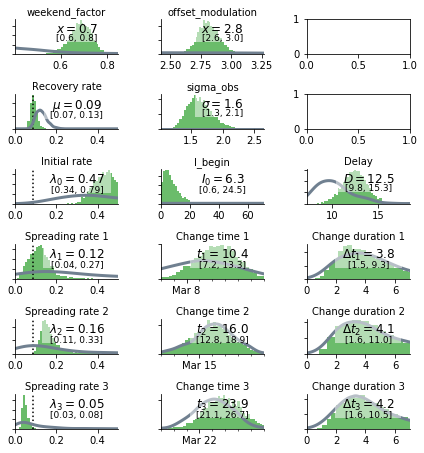

In [17]:
fig.tight_layout()
fig #To print in jupyter notebook


### Timeseries
timeseries overview, for now needs an offset variable to get cumulative cases


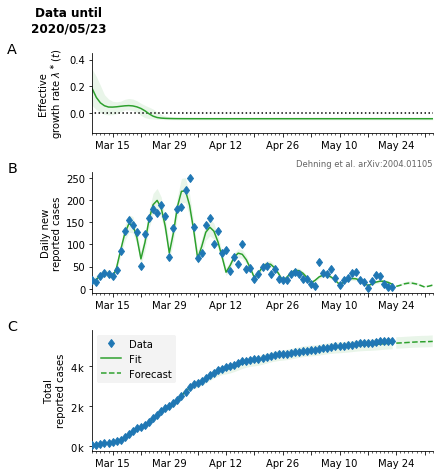

In [19]:
fig, axes = cov19.plot.timeseries_overview(this_model, trace, offset=total_cases_obs[0])